# Stable diffusion with Diffusers

The Stable Diffusion model uses special tools like diffusers and the Stable Diffusion Image Variation pipeline to make images look real.This tool can transform a simple activity like "cooking in the kitchen" into a series of abstract images. It showcases the model's ability to extract and create details based on the given activity prompt. What's interesting is that it only needs one image as a reference to generate a whole sequence of these abstract images, adding depth and complexity to the visual storytelling process.

## Installation
To use this notebook you will need to install diffusers (with your conda environment active) with:
```
pip install --upgrade diffusers\[torch\]
pip install transformers
```

In [1]:
!pip install --upgrade diffusers\[torch\]
!pip install transformers

## Running stable diffusion


In [2]:
import platform
import torch
import numpy as np
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'mps'

## Running StableDiffusionPipeline 
You can set the model version by modifying the `sd_version` variable. 

In [3]:
from diffusers import StableDiffusionPipeline
from diffusers import DPMSolverMultistepScheduler

sd_version = '2.1'

if sd_version == '2.1':
    model_key = "stabilityai/stable-diffusion-2-1-base"
elif sd_version == '2.0':
    model_key = "stabilityai/stable-diffusion-2-base"
elif sd_version == '1.5':
    model_key = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_key, torch_dtype=torch.float16, use_safetensors=True)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config) # Faster scheduler
pipe = pipe.to(device)

if device=='mps':
    # Recommended if your computer has < 64 GB of RAM
    pipe.enable_attention_slicing()
if device=='cuda':
    pipe.enable_sequential_cpu_offload()


/Applications/miniconda3/envs/dmlap/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generate the image (note increasing `num_inference_steps` will improve quality but be slower)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

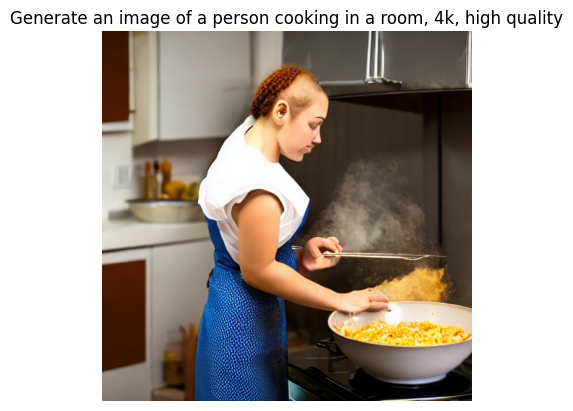

In [4]:
from diffusers import DiffusionPipeline
import torch

# Load the Diffusion Pipeline model
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("mps")
pipe.enable_attention_slicing()

# Define a random seed for reproducibility
torch.manual_seed(123)

# Define the prompt for image generation
prompt = "Generate an image of a person cooking in a room, 4k, high quality"

# Warmup pass if needed (uncomment if necessary)
# _ = pipe(prompt, num_inference_steps=1)

# Generate the image with specified parameters
image = pipe(prompt, guidance_scale=11.5, num_inference_steps=50).images[0]

# Display the generated image
plt.imshow(image)
plt.title(prompt)
plt.axis('off')
plt.show()



## Text guided image to image generation
We can use stable diffusion also with a "seed image", so let's load image. 

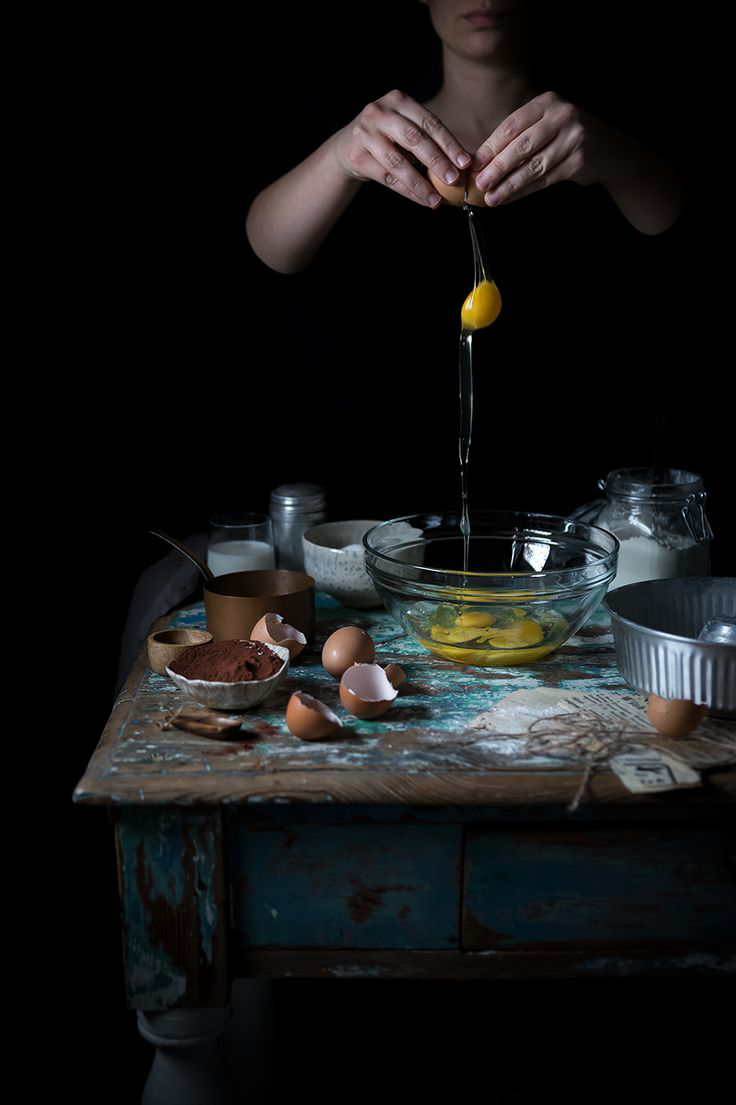

In [5]:
from PIL import Image 

seed_image = Image.open("images/4.jpg")
seed_image

## Runing ImageVariationPipeline

In [6]:
import torch
from diffusers import StableDiffusionImageVariationPipeline
from PIL import Image
import requests
from io import BytesIO

# Initialize the pipeline
pipe = StableDiffusionImageVariationPipeline.from_pretrained(
    "lambdalabs/sd-image-variations-diffusers", revision="v2.0"
)

# Specify the directory path of the input image
image_path = "images/4.jpg"  # Replace this with the actual directory path

# Load the input image using PIL
image = Image.open(image_path).convert("RGB")

# Generate image variations
out = pipe(image, num_images_per_prompt=3, guidance_scale=15)

# Save the generated variations
for i, generated_image in enumerate(out["images"]):
    generated_image.save(f"result_{i}.jpg")


vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The `StableDiffusionImageVariationPipeline` takes an `image` as a prompt parameter to generate the result.jpg:

  0%|          | 0/50 [00:00<?, ?it/s]

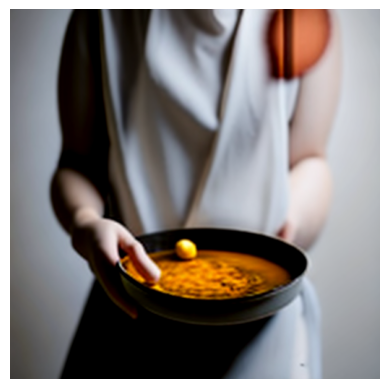

In [7]:
# Adjust the parameters below and try again
image_path = "images/4.jpg"  # Path to the input image
generator_seed = 42
guidance_scale = 10.0
eta = 0.5
num_inference_steps = 50

# Set generator seed
torch.manual_seed(generator_seed)

# Load the input image using PIL
input_image = Image.open(image_path).convert("RGB")

# Generate image variations
generated_image = pipe(input_image, guidance_scale=guidance_scale, eta=eta, num_inference_steps=num_inference_steps).images[0]

# Display the generated image
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.show()

## Generating Image Sequences 
generating images into frame sequence for a video output

In [2]:
import torch
from diffusers import StableDiffusionImageVariationPipeline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Initialize the pipeline
pipe = StableDiffusionImageVariationPipeline.from_pretrained(
    "lambdalabs/sd-image-variations-diffusers", revision="v2.0"
)

# Load the seed image using PIL
seed_image = Image.open("images/4.jpg")

# Adjust the parameters below
generator_seed = 123
guidance_scale = 5.0
num_inference_steps = 50
num_images = 10  # Number of images to generate

# Set the generator seed
torch.manual_seed(generator_seed)

# Generate and save multiple images
for i in range(num_images):
    # Generate image using the seed image
    generated_image = pipe(
        seed_image,
        guidance_scale=guidance_scale,
        generator=torch.Generator().manual_seed(generator_seed + i),
        num_inference_steps=num_inference_steps
    ).images[0]

    # Save the generated image
    plt.imshow(np.array(generated_image))
    plt.axis('off')
    plt.savefig(f"generated_images/generated_image_{i}.jpg", bbox_inches='tight', pad_inches=0)
    plt.close()


/Applications/miniconda3/envs/dmlap/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Now let's use ffmpeg to convert the saved frames to an animated that we can visualize through a separate mp4 file.

In [4]:
import subprocess

# Directory containing the generated images
image_dir = "generated_images"

# Path to the output video file
output_video = "generated_video.mp4"

# Command to generate the video using ffmpeg
ffmpeg_command = [
    "/opt/homebrew/bin/ffmpeg",
    "-y",  # Overwrite output file if it exists
    "-r", "1",  # Frame rate
    "-i", f"{image_dir}/generated_image_%d.jpg",  # Input image pattern
    "-vf", "scale=368:368:force_original_aspect_ratio=decrease,pad=368:368:(ow-iw)/2:(oh-ih)/2",
    "-c:v", "libx264",  # Video codec
    "-pix_fmt", "yuv420p",  # Pixel format
    output_video  # Output file
]

# Run ffmpeg command using subprocess
subprocess.run(ffmpeg_command)

print("Video successfully generated:", output_video)


Video successfully generated: generated_video.mp4


ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino -